* 获取 12个月之前的数据, 为了得到同比
* 获取去年同期的环比
* XGBoost 加上同比数据, 模型效果提升很大, 已经接近 LGB 了
* 将 LGB 训练轮数增加到 1200 , 看看单模型效果
* XGBoost 训练数据减少了, 轮数有没有影响呢? 有影响, 从 4000 降到 3000
* 去掉上月销量, 增加上两月销量

In [594]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [595]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [582]:
# test = train[-140:].reset_index(drop=True)
# train = train[:-140].reset_index(drop=True)

In [583]:
# # 去掉 2012 年数据, 噪音太多
# train = train[train['year']!=2012]

In [584]:
train['sale_date'] = train['year'] * 100 + train['month']
train['sale_date'] = train['sale_date'].astype(int)
train['sale_date'] = pd.to_datetime(train['sale_date'],format='%Y%m',errors = "coerce")
train['sale_date'] = train['sale_date'].dt.to_period('m')

In [585]:
# 获取 12 月前的销量
i = train['sale_date'][0]+11
window = [i-11]
traintmp = pd.DataFrame()
for i in range(59):
    trainSaletmp = train[train['sale_date'].isin(window)]
    trainSaletmp = trainSaletmp.loc[:,['class_id','sale_quantity']]
    trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).sale_quantity.reset_index()
    trainSaletmp['sale_date'] = window[0]+12
    if i == 0:
        traintmp = trainSaletmp
    else:
        traintmp = pd.concat([traintmp, trainSaletmp])
    for j,k in enumerate(window):
        window[j] = window[j] + 1

In [586]:
traintmp.rename(columns={'sale_quantity': 'sale_quantity_last_12M_ago'}, inplace=True)# 替换列名称
train = pd.merge(train, traintmp, on=['class_id','sale_date'], how='left')
# train = train[train['year'] != 2012]
train['sale_quantity_last_12M_ago'].fillna(0, inplace=True)

In [587]:
# 得到销量同比/环比数据
#train['year_relative_ratio'] = train['sale_quantity'] / train['sale_quantity_last_12M_ago']
train['month_relative_ratio'] = train['sale_quantity'] / train['sale_quantity_this_last_month']

train = train.replace([np.inf, -np.inf], np.nan) # 将 inf 转换成 nan
#train['year_relative_ratio'].fillna(0, inplace=True)
train['month_relative_ratio'].fillna(0, inplace=True)

In [588]:
# 获取 12 月前的环比数据
i = train['sale_date'][0]+11
window = [i-11]
traintmp = pd.DataFrame()
for i in range(59):
    trainSaletmp = train[train['sale_date'].isin(window)]
    trainSaletmp = trainSaletmp.loc[:,['class_id','month_relative_ratio']]
    trainSaletmp = trainSaletmp.groupby(['class_id']).agg(sum).month_relative_ratio.reset_index()
    trainSaletmp['sale_date'] = window[0]+12
    if i == 0:
        traintmp = trainSaletmp
    else:
        traintmp = pd.concat([traintmp, trainSaletmp])
    for j,k in enumerate(window):
        window[j] = window[j] + 1

In [589]:
traintmp.rename(columns={'month_relative_ratio': 'month_relative_ratio_12M_ago'}, inplace=True)# 替换列名称
train = pd.merge(train, traintmp, on=['class_id','sale_date'], how='left')
train = train[train['year'] != 2012]
train['month_relative_ratio_12M_ago'].fillna(0, inplace=True)
labels = train['sale_quantity']
train = train.drop(['sale_date', 'class_id', 'sale_quantity', 'month_relative_ratio', 'month_relative_ratio_12M_ago'], axis=1)

In [590]:
train = train.drop(['month_relative_ratio'], axis=1)
train.to_csv('../../raw/LiChuan/dataset.csv',index=False, header=True)  

# 注意: 到这里就生成了 dataset

In [276]:
test = train[-140:].reset_index(drop=True)
train = train[:-140].reset_index(drop=True)

In [175]:
labels = labels[:-140]

In [66]:
# labels = train['sale_quantity']
# year_dummies = pd.get_dummies(train['year'], prefix='year')
# month_dummies = pd.get_dummies(train['month'], prefix='month')
# train = pd.concat([train, year_dummies], axis=1)
# train = pd.concat([train, month_dummies], axis=1)
# train = train.drop(['year', 'month'], axis=1)
# train.fillna(0.0, inplace=True)
# train = train.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [67]:
# # 热力散点图
# k = 20 #number of stdiables for heatmap
# corrmat = train.corr()
# cols = corrmat.nlargest(k, 'sale_quantity')['sale_quantity'].index
# cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
# fig = plt.gcf()
# fig.set_size_inches(18, 15)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

In [591]:
# 获取 2017-9 作为测试集
x_test = train[-140:]
y_test = labels[-140:]

# 2013-01 至 2017-8 作为训练集
train = train[:-140]
labels = labels[:-140]

In [69]:
# 将销量大于 1000 的车型, 预测设为实际值
# train['sale_quantity_this_last_month'][(train['sale_quantity'] > 1000)&(train['year']==2017)&(train['month']==10)] = train[(train['sale_quantity'] > 400)&(train['year']==2017)&(train['month']==10)]['sale_quantity']

In [133]:
predict_quantity = test['sale_quantity_this_last_month']

In [71]:
sp.sqrt(sp.mean((y_test - predict_quantity*0.94) ** 2))

NameError: name 'y_test' is not defined

In [17]:
#train['sale_date'] = train['sale_date'].astype(str) # 为了绘图下标正常

## 测试环比均方根

In [12]:
# 对12个月前 环比 >2, <0.1 的离群点, 取1
train.loc[ train['month_relative_ratio_12M_ago'] < 0.2, 'month_relative_ratio_12M_ago'] = 1
train.loc[ train['month_relative_ratio_12M_ago'] > 1.5, 'month_relative_ratio_12M_ago'] = 1

In [203]:
last_month_quantity = train[(train['year']==2017)&(train['month']==9)]['sale_quantity'].values
this_month_relative_ratio_12M_ago = train[(train['year']==2017)&(train['month']==10)]['month_relative_ratio_12M_ago'].values
predict_quantity = last_month_quantity * this_month_relative_ratio_12M_ago

In [204]:
predict_quantity = train[(train['year']==2017)&(train['month']==9)]['sale_quantity'].values

In [205]:
labels = train[(train['year']==2017)&(train['month']==10)]['sale_quantity'].values

In [206]:
sp.sqrt(sp.mean((labels - predict_quantity) ** 2))

141.00790251410936

# 测试 LGBMRegressor

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import lightgbm as lgb

In [16]:
# 定义交叉验证函数
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, labels, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [17]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=1100,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=5, min_sum_hessian_in_leaf=11)

In [18]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 186.3699 (54.8625)



In [19]:
model_lgb.fit(train, labels)
predict_lgb = model_lgb.predict(x_test)

In [33]:
sp.sqrt(sp.mean((y_test - predict_lgb) ** 2))

146.76104391491327

# 测试 LightGBM

In [23]:
rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_test = lgb.Dataset(test_X, test_y)
    
    params = {
    'learning_rate': 0.002,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.8,
    'num_leaves': 31,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,}
    
    gbm = lgb.train(params,lgb_train, 900)
    pred = gbm.predict(test_X)
    rmsetmp = sp.sqrt(sp.mean((test_y - pred) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 269.582797518
This time rmse is: 148.804900926
This time rmse is: 175.677512375
This time rmse is: 176.606081424
This time rmse is: 186.613879593
Mean rmse of these is:191.457034367


In [156]:
lgb_train = lgb.Dataset(train, labels)
#lgb_test = lgb.Dataset(x_test, y_test)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

gbm = lgb.train(params,lgb_train,1200)
pred = gbm.predict(test)
# rmsetmp = sp.sqrt(sp.mean((y_test - pred) ** 2))

# print('This time rmse is: '+ str(rmsetmp))

Features importance...
                            feature       gain  split
159       sale_quantity_last_3M_sum  28.443349    804
171       sale_quantity_last_2M_sum  21.079405   1096
144   sale_quantity_this_last_month  11.024515   3729
162      sale_quantity_last_3M_mean   7.213076    165
170    sale_quantity_last_6M_median   6.703637   1329
161       sale_quantity_last_3M_min   5.641489   1181
174      sale_quantity_last_2M_mean   4.282643    212
183      sale_quantity_last_12M_ago   3.676951   2975
116                           month   1.516750   5868
164    sale_quantity_last_3M_median   1.513234   1230
173       sale_quantity_last_2M_min   1.355348   1138
177      sale_quantity_last_12M_sum   0.841415    552
145  sale_quantity_total_last_month   0.706109   3345
176    sale_quantity_last_2M_median   0.591425     31
178      sale_quantity_last_12M_max   0.525624    545
184    month_relative_ratio_12M_ago   0.480741   1755
182   sale_quantity_last_12M_median   0.437038   1091
160  

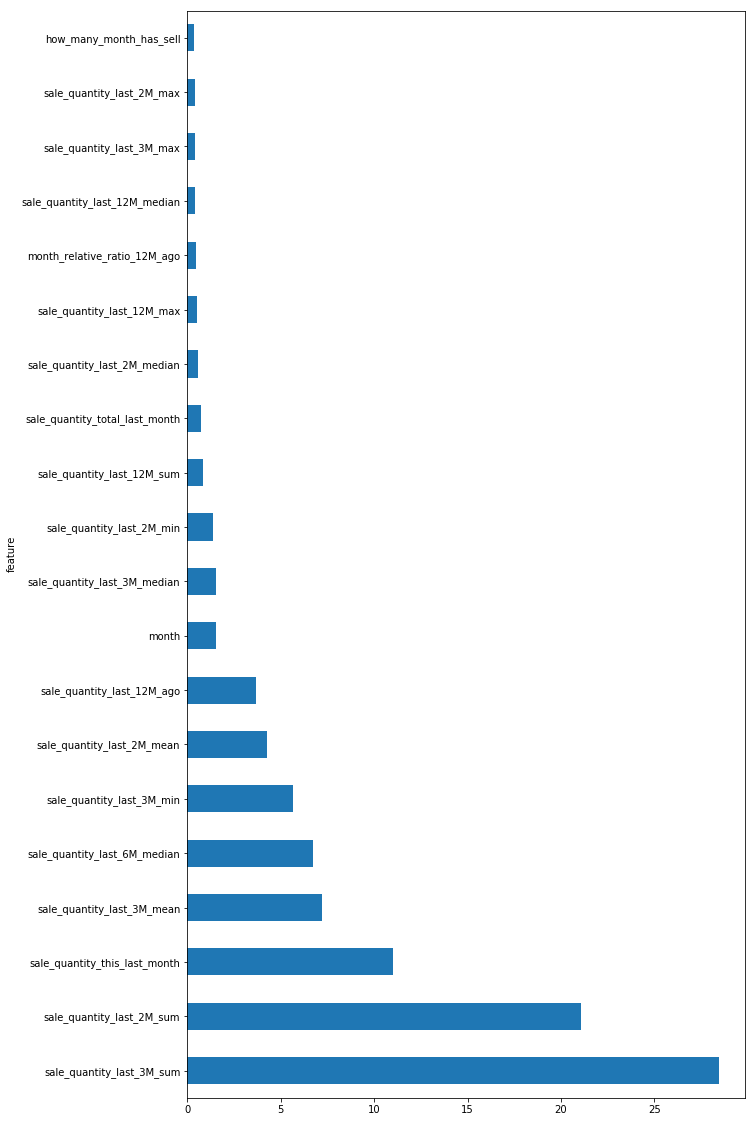

In [251]:
print("Features importance...")
gain = gbm.feature_importance('gain')
ft = pd.DataFrame({'feature':gbm.feature_name(), 'split':gbm.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft.head(25))

plt.figure()
ft[['feature','gain']].head(20).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 20))
plt.gcf().savefig('features_importance.png')

In [20]:
submit['predict_quantity'] = pred
submit.to_csv('../../raw/LiChuan/result_20180221_lightGBM-monthrelative.csv',index=False, header=True)  

# XGBoost 测试

In [176]:
import xgboost as xgb

In [22]:
# # 原始版本参数 RMSE = 141, 2018年02月01日
# rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model = xgb.train(params, trainset, num_boost_round=4000)
    predict_test_X = model.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

This time rmse is: 185.195315362
This time rmse is: 164.516406047
This time rmse is: 194.623868657
This time rmse is: 245.665422927
This time rmse is: 186.070788161
Mean rmse of these is:186.949001753


In [593]:
trainset = xgb.DMatrix(train,label=labels)
testset = xgb.DMatrix(x_test)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000)
predict_xgb = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((y_test - predict_xgb) ** 2))

print('This time rmse is: '+ str(rmsetmp))

This time rmse is: 149.645989418


In [ ]:
9月 121/ 10 月 149

- 只加同比
    * 2017-09 测试
        * round 4000 121.02
        * round 3500 121.02
        * round 3000 120.99 最佳
        * round 2500 121.06
        * round 2900 121.00
    * 2017-08 测试
        * round 3000 123.95
        * round 2800 123.94
    * 2017-10 测试
        * round 3000 127.92
        * round 3100 127.95
- 加上环比(不能加)
    * 2017-10 测试
        * round 3100 144.26
- 去掉上月销量, 增加前2月销量
    * 2017-10 测试
        * round 3000 127.96
    * 2017-09 测试
        * round 3000 187.78
    * 2017-08 测试
        * round 3000 145.76

In [303]:
(120.99 + 123.95 + 127.92)/3

124.28666666666668

In [147]:
sp.sqrt(sp.mean((predict_lstm - predict_quantity*1.1) ** 2))

84.722242305562389

In [79]:
submit['predict_quantity'] = predict_xgb
submit.to_csv('../../raw/LiChuan/result_20180221_xgboost-monthrelative.csv',index=False, header=True)  

In [21]:
sp.sqrt(sp.mean((y_test - predict_xgb*0.5 - predict_quantity*0.94*0.5) ** 2))

126.69942398400659

In [22]:
sp.sqrt(sp.mean((y_test - predict_quantity*0.94*0.4 - predict_xgb*0.2 - pred*0.4) ** 2))

122.54222306698628

In [74]:
xgb = pd.read_csv('../../raw/Submissions/result_20180202_2.csv')
predict_xgb = xgb['predict_quantity']

In [75]:
lstm = pd.read_csv('../../raw/Submissions/result_20180221_lstm.csv')
predict_lstm = lstm['predict_quantity']

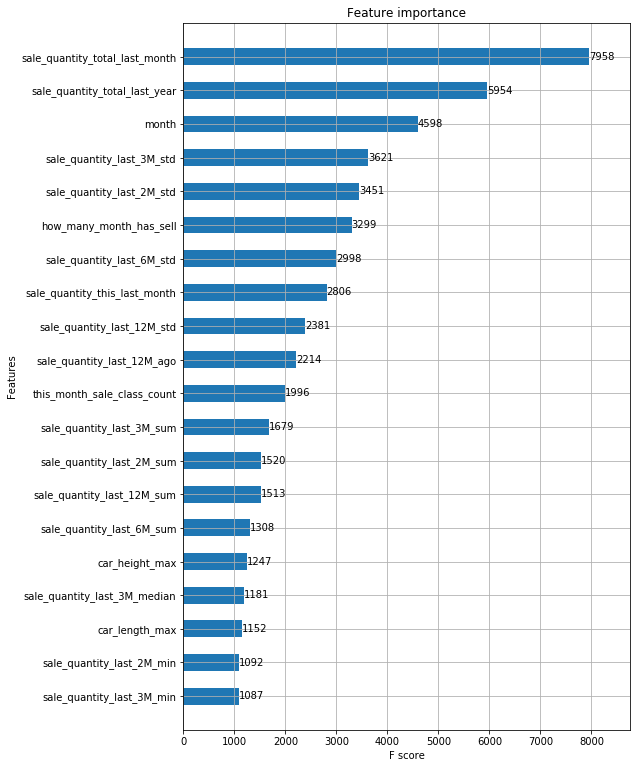

In [528]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

## 0221 测试数据

In [ ]:
predictions = predict_xgb*0.3 + predict_quantity*1.1*0.4 + pred*0.3

In [148]:
predictions2 = predict_xgb*0.25 + predict_quantity*1.1*0.25 + pred*0.25 + predict_lstm*0.25

In [130]:
submit['predict_quantity'] = predictions
submit.to_csv('../../raw/LiChuan/result_20180221_xgb*0.3_base*1.1*0.4_lightGBM*0.3.csv',index=False, header=True)  

In [149]:
submit['predict_quantity'] = predictions2
submit.to_csv('../../raw/LiChuan/result_20180221_xgb*0.25_base*1.1*0.25_lightGBM*0.25_lstm*0.25.csv',index=False, header=True)  

## 0222 测试数据

In [159]:
predictions = predict_quantity*1.1*0.56 + pred*0.44

In [257]:
predictions2 = pred

In [161]:
submit['predict_quantity'] = predictions
submit.to_csv('../../raw/LiChuan/result_180222_base*0.56_lightGBM*0.44.csv',index=False, header=True)  

In [258]:
submit['predict_quantity'] = predictions2
submit.to_csv('../../raw/LiChuan/result_180223_lightGBM.csv',index=False, header=True)  

In [135]:
rmse_1 = sp.sqrt(sp.mean((predict_quantity*1.1 - pred) ** 2))

rmse_2 = sp.sqrt(sp.mean((predict_quantity*1.1 - predict_lstm) ** 2))

rmse_3 = sp.sqrt(sp.mean((predict_quantity*1.1 - predict_xgb) ** 2))

print(rmse_1, rmse_2, rmse_3)

101.61270123 84.7222423056 78.1862653158


In [144]:
rmse_1 = sp.sqrt(sp.mean((predict_quantity*1.1 - pred) ** 2))

rmse_2 = sp.sqrt(sp.mean((pred - predict_lstm) ** 2))

rmse_3 = sp.sqrt(sp.mean((pred - predict_xgb) ** 2))

print(rmse_1, rmse_2, rmse_3)

100.761110332 101.226513657 81.5441171936


99.5391294824 95.7129748838 78.9288837102

101.61270123 94.0858585533 79.7309932661

105.258803606 86.2601049527 81.2259375051

In [80]:
rmse_1 = sp.sqrt(sp.mean((predict_quantity*1.1 - predict_lstm) ** 2))

rmse_2 = sp.sqrt(sp.mean((pred - predict_lstm) ** 2))

rmse_3 = sp.sqrt(sp.mean((predict_lstm - predict_xgb) ** 2))

print(rmse_1, rmse_2, rmse_3)

84.7222423056 86.2601049527 88.742383265


In [81]:
rmse_1 = sp.sqrt(sp.mean((predict_quantity*1.1 - predict_xgb) ** 2))

rmse_2 = sp.sqrt(sp.mean((pred - predict_xgb) ** 2))

rmse_3 = sp.sqrt(sp.mean((predict_lstm - predict_xgb) ** 2))

print(rmse_1, rmse_2, rmse_3)

78.1862653158 81.2259375051 88.742383265


## 测试销售 36 个月以上的均方根

### 直接用上个月销量乘以系数测试

In [14]:
labels = train[(train['how_many_month_has_sell'] > 48)&(train['year']==2017)&(train['month']==10)]['sale_quantity'].values

In [15]:
predict_quantity = train[(train['how_many_month_has_sell'] > 48)&(train['year']==2017)&(train['month']==10)]['sale_quantity_this_last_month'].values

In [16]:
last_month_quantity = train[(train['how_many_month_has_sell'] > 48)&(train['year']==2017)&(train['month']==10)]['sale_quantity_this_last_month'].values
this_month_relative_ratio_12M_ago = train[(train['how_many_month_has_sell'] > 48)&(train['year']==2017)&(train['month']==10)]['month_relative_ratio_12M_ago'].values
predict_quantity = last_month_quantity * this_month_relative_ratio_12M_ago

In [23]:
predict_quantity - labels

array([ -24.53441296,   -9.36842105,   35.975     ,   63.95907473,
        -52.18050542,  272.85152838,   79.925     ,    1.1291866 ,
        -53.90265487, -267.0805336 , -411.40060976,  291.52053274,
          7.        ,  111.58730159,  -86.79351351, -531.89829129,
        191.        ,   70.96551724,   59.        ,  174.46443515,
        182.48387097,   51.44915254,   86.90168539, -111.552     ,
         27.57655039, -116.50537634,   46.85308057, -109.63636364,
        -34.79775281,   68.95588235,  163.57627119,  293.60649819,
       -124.88865711,  127.71561772,   22.        ,  103.20689655,
        -18.63636364,   29.62318841,  266.60416667,   25.38151659,
         47.22617124,   45.        ,    2.71976967, -783.83358321,
         -2.28571429,  -23.        ,   58.68376068, -184.26184539,
        -45.65289256,   69.25925926,   10.55319149,  160.49411765,
         21.56029685,  147.        ,   -4.47058824])

In [18]:
predict_quantity = predict_quantity

In [19]:
sp.sqrt(sp.mean((labels - predict_quantity) ** 2))

182.27534042671317

In [24]:
predict_quantity

array([  131.46558704,   152.63157895,   183.975     ,   154.95907473,
         207.81949458,   601.85152838,   284.925     ,   321.1291866 ,
         319.09734513,  1918.9194664 ,   529.59939024,   751.52053274,
         140.        ,   876.58730159,  1588.20648649,  1316.10170871,
         381.        ,   216.96551724,   143.        ,   351.46443515,
         336.48387097,   155.44915254,   260.90168539,   296.448     ,
         167.57655039,   297.49462366,   372.85308057,   636.36363636,
         188.20224719,   349.95588235,   355.57627119,   724.60649819,
        1887.11134289,   221.71561772,   276.        ,   586.20689655,
          54.36363636,   109.62318841,   470.60416667,   667.38151659,
         899.22617124,    95.        ,   106.71976967,  2114.16641679,
         180.71428571,   214.        ,   138.68376068,   206.73815461,
          42.34710744,   224.25925926,   149.55319149,   322.49411765,
        1083.56029685,   623.        ,    70.52941176])

In [21]:
labels

array([  156.,   162.,   148.,    91.,   260.,   329.,   205.,   320.,
         373.,  2186.,   941.,   460.,   133.,   765.,  1675.,  1848.,
         190.,   146.,    84.,   177.,   154.,   104.,   174.,   408.,
         140.,   414.,   326.,   746.,   223.,   281.,   192.,   431.,
        2012.,    94.,   254.,   483.,    73.,    80.,   204.,   642.,
         852.,    50.,   104.,  2898.,   183.,   237.,    80.,   391.,
          88.,   155.,   139.,   162.,  1062.,   476.,    75.])

- 1 年 以内 83
- 1 年 - 2 年 114
- 2 年 - 3 年 124
- 3 年 - 4 年 78
- 4 年 以上 187

In [22]:
train[(train['how_many_month_has_sell'] > 48)&(train['year']==2017)&(train['month']==10)]

,how_many_month_has_sell,class_id,sale_date,sale_quantity,sale_quantity_this_last_month,year,month,sale_quantity_last_12M_ago,year_relative_ratio,month_relative_ratio,month_relative_ratio_12M_ago
9660,70.0,125403,2017-10,156.0,328.0,2017.0,10.0,99.0,1.575758,0.475610,0.400810
9661,70.0,136916,2017-10,162.0,145.0,2017.0,10.0,180.0,0.900000,1.117241,1.052632
9662,70.0,178529,2017-10,148.0,165.0,2017.0,10.0,223.0,0.663677,0.896970,1.115000
9665,70.0,209945,2017-10,91.0,273.0,2017.0,10.0,319.0,0.285266,0.333333,0.567616
9666,70.0,248352,2017-10,260.0,269.0,2017.0,10.0,428.0,0.607477,0.966543,0.772563
9667,70.0,281301,2017-10,329.0,584.0,2017.0,10.0,708.0,0.464689,0.563356,1.030568
9668,70.0,290854,2017-10,205.0,393.0,2017.0,10.0,232.0,0.883621,0.521628,0.725000
9669,70.0,291086,2017-10,320.0,376.0,2017.0,10.0,714.0,0.448179,0.851064,0.854067
9670,70.0,304458,2017-10,373.0,605.0,2017.0,10.0,298.0,1.251678,0.616529,0.527434
9671,70.0,321683,2017-10,2186.0,2067.0,2017.0,10.0,1879.0,1.163385,1.057571,0.928360


# 观察同比

In [376]:
average_year_ratio = []
for i in range(1, 13):
    year_ratio = train[(train['year']==2013)&(train['month']==i)&(0.1<train['year_relative_ratio'])&(train['year_relative_ratio']<20)]['year_relative_ratio'].mean()
    print('{} month year ratio is: {:.3f}'.format(i, year_ratio))

1 month year ratio is: 1.390
2 month year ratio is: 1.382
3 month year ratio is: 1.440
4 month year ratio is: 1.883
5 month year ratio is: 1.957
6 month year ratio is: 1.277
7 month year ratio is: 1.264
8 month year ratio is: 1.306
9 month year ratio is: 1.679
10 month year ratio is: 1.719
11 month year ratio is: 1.633
12 month year ratio is: 1.258


## 观察环比

In [493]:
# 看 月份 环比平均值, 去掉离群点
average_ratio = []
for i in range(2013, 2017):
    month_ratio = train[(train['month'] == 8)&(train['year']==i)&(0.1<train['month_relative_ratio'])&(train['month_relative_ratio']<2)]['month_relative_ratio'].mean()
    print(month_ratio)
    average_ratio.append(month_ratio)
print('the average ratio is: {}'.format((sum(average_ratio))/len(average_ratio)))

1.04844580405
0.89649133171
1.08052034806
1.13729409314
the average ratio is: 1.0406878942397282


去掉离群点后, 每月环比呈现 周期性

In [17]:
307.0 * 0.695402

213.48841399999998

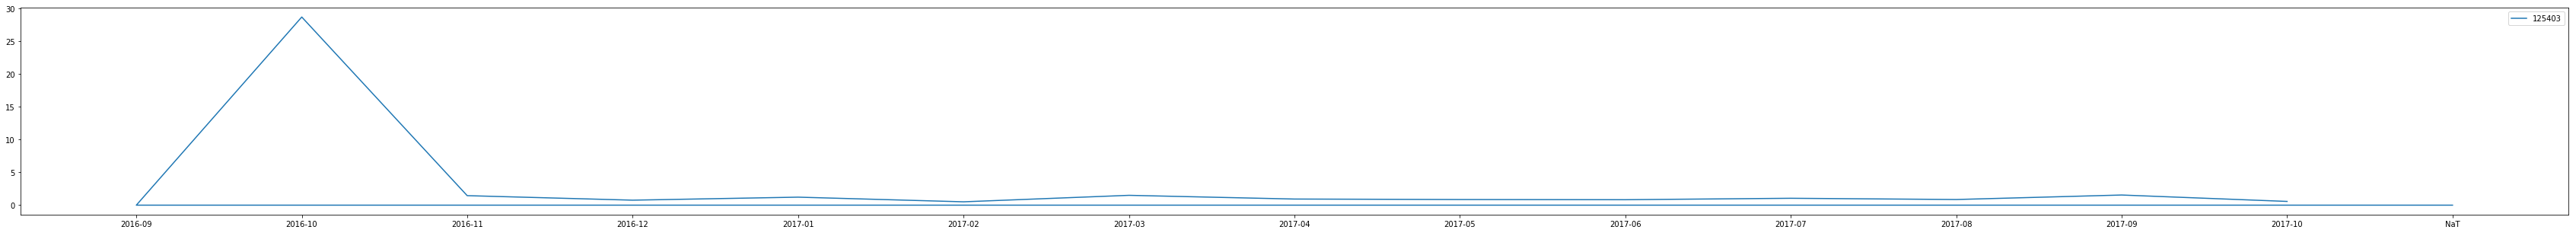

In [176]:
df=train[train['class_id'] ==890189]
plt.figure(figsize=(60,5))
plt.plot(df['sale_date'],df['month_relative_ratio'],label='125403')
plt.legend()
plt.show()

In [31]:
labels = np.array([10000])
predict_quantity = np.array([11000])

In [32]:
sp.sqrt(sp.mean((labels - predict_quantity) ** 2))

1000.0

In [36]:
labels = np.array([50])
predict_quantity = np.array([100])

In [37]:
sp.sqrt(sp.mean((labels - predict_quantity) ** 2))

50.0